# Background

This notebook provides a sample code on how to deploy Keras Image Classification model (VGG16) on Sagemaker Managed Hosting service. As model server, we use Sagemaker Multi Model Server (MMS). We use pre-trained VGG16 model avialable in Keras Model Zoo.

Sample code is provided "as is" without any guarantees.

### Updating Sagemaker SDK

We use Sagemaker Python SDK to deploy endpoints. Before we beging, we let's update this SDK to the latest version. Note, after this upgrade please restart your Jupyter kernel for change to take effect.

In [ ]:
! pip install --upgrade sagemaker

## Build Custom Serving Container

In this example, we buid custom inference container from scratch. As part of this container, we also package our inference code.

### Initiate Sagemaker variables
Below, we import required packaged and define common configuration variables.

In [1]:
import sagemaker, boto3
from sagemaker import get_execution_role

session = sagemaker.Session()
region = session.boto_region_name
role = get_execution_role()
account = boto3.client('sts').get_caller_identity().get('Account')
bucket = session.default_bucket()

model_name="vgg16-model"
endpoint_name= model_name+"-mms-endpoint"
tag = "v1"
image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{model_name}:{tag}"

Login to private ECR.

In [5]:
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account}.dkr.ecr.{region}.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


### Review serving image

In [6]:
! pygmentize Dockerfile

FROM ubuntu:18.04

LABEL maintainer="vadimd@amazon.com"
# Set a docker label to advertise multi-model support on the container
LABEL com.amazonaws.sagemaker.capabilities.multi-models=false
# Set a docker label to enable container to use SAGEMAKER_BIND_TO_PORT environment variable if present
LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true

ARG PYTHON=python3
ARG PIP=pip3
ARG TF_VERSION=2.1.0

# See http://bugs.python.org/issue19846
ENV LANG=C.UTF-8
# Python won’t try to write .pyc or .pyo files on the import of source modules
ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

# Install necessary dependencies for MMS and SageMaker Inference Toolkit
RUN apt-get update && \
    apt-get -y install --no-install-recommends \
    build-essential \
    ca-certificates \
    openjdk-8-jdk-headless \
    python3-dev \
    curl \
    vim \
    && rm -rf /var/lib/apt/lists/* \
    && curl -O https://bootstrap.pypa.io/get-pip.py \
    && python3 get-pip.py

RUN apt-get update 

### Review inference code

In case of Sagemaker MMS, you need to create two files:
- `dockerd_entrypoint.py` - a handler service, which will be executed by MMS;
- `model_handler.py` - a handler to load model, run predictions, pre- and post-process the inference inputs.

You can find more details about these files and recruiments here: https://github.com/aws/sagemaker-inference-toolkit/#implementation-steps

In [114]:
! pygmentize serving_src/dockerd_entrypoint.py

import subprocess
import sys
import shlex
import os
from retrying import retry
from subprocess import CalledProcessError
from sagemaker_inference import model_server

def _retry_if_error(exception):
    return isinstance(exception, CalledProcessError or OSError)

@retry(stop_max_delay=1000 * 50,
       retry_on_exception=_retry_if_error)
def _start_mms():
    # by default the number of workers per model is 1, but we can configure it through the
    # environment variable below if desired.
    # os.environ['SAGEMAKER_MODEL_SERVER_WORKERS'] = '2'
    model_server.start_model_server(handler_service='/home/model-server/model_handler.py:handle')

def main():
    if sys.argv[1] == 'serve':
        _start_mms()
    else:
        subprocess.check_call(shlex.split(' '.join(sys.argv[1:])))

    # prevent docker exit
    subprocess.call(['tail', '-f', '/dev/null'])
    
main()


In [115]:
! pygmentize serving_src/model_handler.py

from collections import namedtuple
import glob
import json
import logging
import os
import re

import numpy as np
from sagemaker_inference import content_types, encoder


import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

IMAGE_SHAPE = (1, 224, 224, 3)

class ModelHandler(object):
    """
    Keras VGG pre-trained model classifier
    """

    def __init__(self):
        self.initialized = False
        self.model = None

    def initialize(self, context):
        """
        Initialize model. This will be called during model loading time
        :param context: Initial context contains model server system properties.
        :return: None
        """
        self.initialized = True
        properties = context.system_properties
        model_dir = properties.get("model_dir") 
        
     

### Build and push container to ECR registry

We are ready to build and push our custom serving image to ECR!

In [ ]:
!./build_and_push.sh {model_name} {tag}

# Deploy and test Sagemaker Endpoint

Now we have our serving image available in ECR, we are ready to deploy our endpoint to Sagemaker Hosting.

First, we have to create a Sageamaker Model which defines parameters of model such as model data (we skip because we load model using Keras facility) and serving image (we set it to our serving image).

In [15]:
from sagemaker import Model

mms_model = Model(
    image_uri=image_uri,
    model_data=None,
    role=role,
    name=model_name,
    sagemaker_session=session
)

Once model is created, we now deploy this model on the endpoint. Sagemaker Endpoint allows to configure such parameters as number and type of EC2 instances. 

In [ ]:
mms_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge", 
    endpoint_name=endpoint_name
)

For testing purposes we take one of the images from ImageNet dataset, and resize it to fit VGG16 model requirements.

In [ ]:
! wget https://farm1.static.flickr.com/56/152004091_5bfbc69bb3.jpg

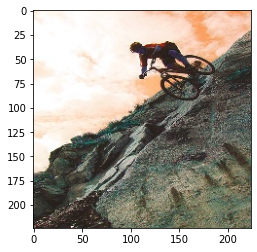

In [3]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = cv2.imread('152004091_5bfbc69bb3.jpg')
resized_img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
resized_filename = "resized_image.jpg"

cv2.imwrite(resized_filename, resized_img)

plt.imshow(cv2.imread(resized_filename))
plt.show()

To send this image for prediction, we use boto3 `sagemaker-runtime` client. We read the image and send it as payload to Sagemaker endpoint. We expect to get most likely label back.

In [4]:
import boto3

client = boto3.client('sagemaker-runtime')
accept_type = "json"
content_type = 'image/jpeg'
headers = {'content-type': content_type}
payload = open(resized_filename, 'rb')

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    Accept = accept_type
)


most_likely_label = response['Body'].read()

print(most_likely_label)

b'"mountain_bike"'
